<a href="https://colab.research.google.com/github/dewnijayasuriya/DL-LAB07/blob/main/Markov_Decision_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Decision Process (MDP)

### Ransalu Senanayake

In [ ]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [ ]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0) # Ensures x and y are within [0,9] (edges of grid).
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))  # Converts 1D state index → 2D coordinates.
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'): # Plots the grid with colors representing values
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down'] # A → possible actions
    S = np.arange(100) # S → all 100 states (0 to 99)
    T = np.zeros((len(S), len(A), len(S))) # T[s,a,s'] → probability of moving from s to s' using action a
    R = np.zeros((len(S), len(A))) # R[s,a] → reward for taking action a in state s.
    for s in S: # Set Rewards
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3 # The : means reward is the same for all actions in that state.
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            # Define Transition Probabilities
            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7 # Probability 0.7 → intended direction.
                    T[s, 0, xy2s(x + 1, y)] += 0.1 # Probability 0.1 → each other direction (stochasticity).
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7 # 70% chance → right
                    T[s, 1, xy2s(x - 1, y)] += 0.1 # 10% chance → left
                    T[s, 1, xy2s(x, y - 1)] += 0.1 # 10% chance → up
                    T[s, 1, xy2s(x, y + 1)] += 0.1 # 10% chance → down
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:  # Additional penalties for corners when moving outside.
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9 # Future rewards are discounted by 0.9 per step.

    nextStates = {} # Creates a dictionary of possible next states for each (state, action) pair.
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    # Returns all MDP parameters as a dictionary for easy access.
    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [ ]:
class MDP(): # Defines a new class called MDP.
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict): # This method initializes the MDP object using a dictionary, usually the one returned by createGrid10World().
        self.S = mdp_dict['S'] # List of all states (0–99 for 10×10 grid)
        self.A = mdp_dict['A'] # List of all actions (left, right, up, down)
        self.T = mdp_dict['T'] # Transition probability matrix T[s, a, s']
        self.R = mdp_dict['R'] # Reward matrix R[s, a]
        self.discount = mdp_dict['discount'] # Discount factor γ (future reward weighting)
        self.nextStates = mdp_dict['nextStates'] # Dictionary of possible next states for (state, action)
        self.gridPlot = mdp_dict['gridPlot'] # Function to plot a grid (visualize rewards or values)
        self.xy2s = mdp_dict['xy2s'] # Function to convert 2D coords → 1D state
        self.s2xy = mdp_dict['s2xy'] # Function to convert 1D state → 2D coords

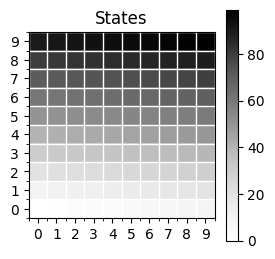

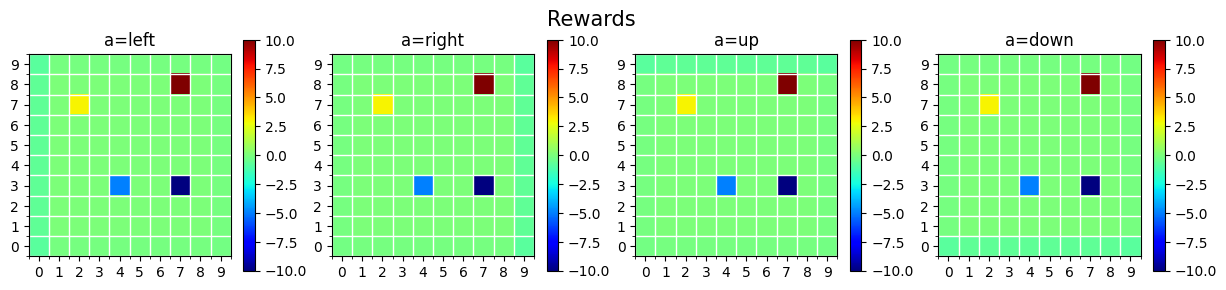

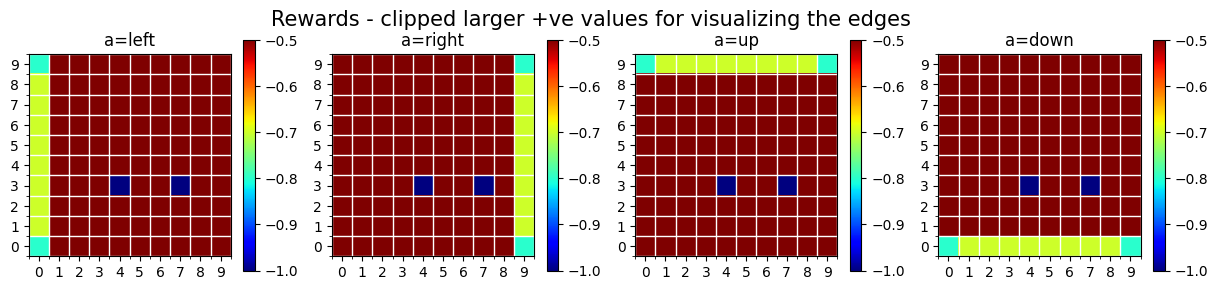

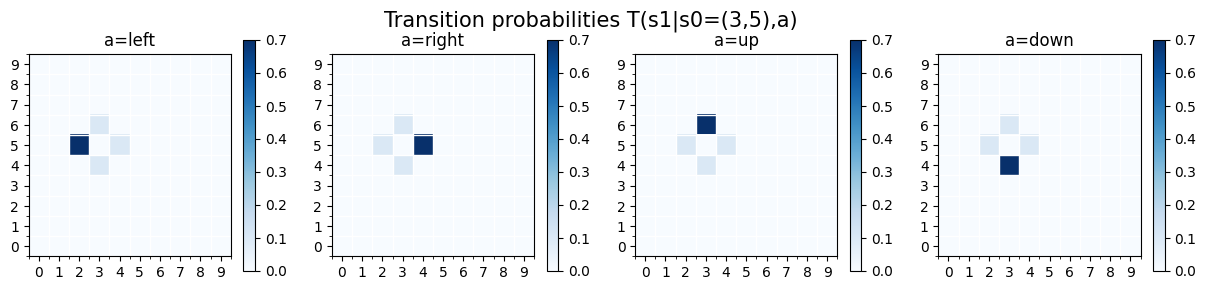

In [ ]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4): # oops through each action a=0..3 (left, right, up, down).
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
    # mdp.R[:,a] → rewards for all states for action a.
    # .reshape((10,10)) → make it a grid.
    # subplot(1,4,a+1) → plots 4 grids in a row (one for each action).
    # cmap='jet' → colorful heatmap to show positive/negative rewards.
pl.show()

#Plot rewards. Plot clipped rewards (focus on edges)
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15) # Clipping makes small negative rewards visible, like edge penalties and bounce-back penalties.
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards (Plot transition probabilities from a specific state)
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1) # Darker → higher probability (0.7 in intended direction, 0.1 in other directions).
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [ ]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action): # This function plots the probability of moving from one state to all others given an action.
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

In Markov Decision Processes (MDP), policy evaluation computes the utility (value) of each state under a fixed policy
𝜋
π.

This will compute expected utility for each state under a fixed action, and your plots will visually show which states are more valuable.

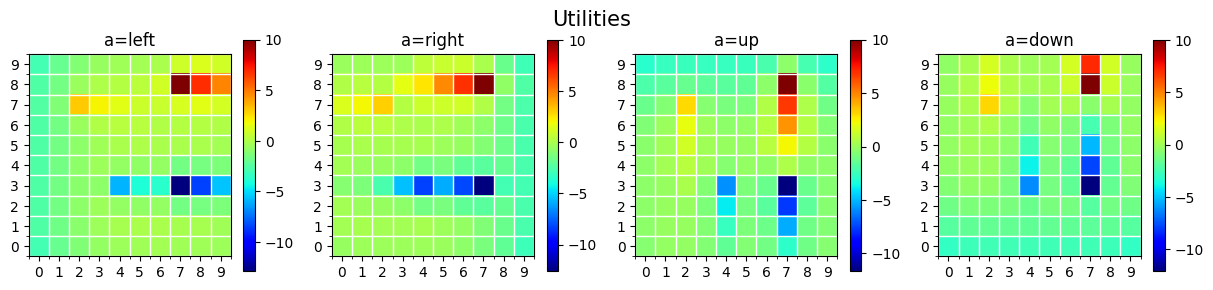

In [ ]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    for t in range(numIterations):
        #type your code here
        U_old = U.copy()  # copy previous utilities
        for s in mdp.S:
            a = policy   # here, policy is a fixed action (0-3)
            # sum over all possible next states
            U[s] = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_old)
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4): # Loops over 4 actions: left, right, up, down.
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations) # Computes utility U for each action as a fixed policy.
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet') # Plots a heatmap of utility values in a 10×10 grid.
pl.show()
#print(np.round(U.reshape(10,10),3)) Shows utility values for all states rounded to 3 decimals.

This code builds an interactive visualization tool where you can choose:

which fixed action policy to evaluate, and

how many iterations of evaluation to run,

and it will plot the utility values of all states in the gridworld.

In [ ]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter) # mdp.A.index(action) → converts the action name (like "left") into its index (0, 1, 2, 3).
    # Calls policy evaluation for that action:
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet') # Reshape U into a 10×10 grid (since states are arranged in a gridworld).
    # mdp.gridPlot(...) → shows the utilities as a heatmap with colors (jet colormap).
    pl.show()

# Interactive widget
interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

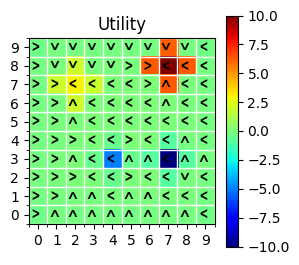

In [ ]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    # U_old = copy.copy(U)
    for t in range(numIterations):
        #type your code here
        U_old = copy.copy(U)
        for s in mdp.S:  # loop over states
            U[s] = max([ # Take the max over all actions
                mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_old) # Compute expected utility of each possible action a.
                for a in range(len(mdp.A))
            ])
    return U

# Policy Extraction uses those utilities to pick the best action in each state.
def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    #type your code here
    for s in mdp.S:
        q_values = [
            mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U)
            for a in range(len(mdp.A))
        ]
        policy[s] = np.argmax(q_values)  # best action index
    return policy

U = valueIteration(mdp, numIterations=2) # run for 2 iterations
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100): #  loop over all 100 states
    x, y = mdp.s2xy(s) # convert index to grid coordinates
    if policy[s] == 0:
        m='\u02C2' # left
    elif policy[s] == 1:
        m='\u02C3' # right
    elif policy[s] == 2:
        m='\u02C4'  # up
    elif policy[s] == 3:
        m='\u02C5' # down
    pl.text(x-0.5,y-1,m,color='k',size=20) # draw arrow on grid

pl.show()

In [ ]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [ ]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S)) #initial values
    pi_k = np.random.randint(low=0,high=4,size=len(mdp.S),dtype=int) #initial policy
    pi_kp1 = copy.copy(pi_k)
    for t in range(numIterations):
        # 1. Policy evaluation: compute U_pi_k
          #type your code here
          for _ in range(10):  # run multiple sweeps to approximate evaluation
            U_old = copy.copy(U_pi_k)
            for s in mdp.S:
                a = pi_k[s]  # action chosen by current policy
                U_pi_k[s] = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_old)
        # 2. Policy improvement
          #type your code here
          for s in mdp.S:
            q_values = [
                mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_pi_k)
                for a in range(len(mdp.A))
            ]
            pi_kp1[s] = np.argmax(q_values)  # best action for this state

             # 3. Check if policy changed
            if np.array_equal(pi_k, pi_kp1):
              print(f"Policy converged at iteration {t+1}")
              break
            else:
              pi_k = copy.copy(pi_kp1)
    return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

Policy converged at iteration 1
Policy converged at iteration 2


In [ ]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

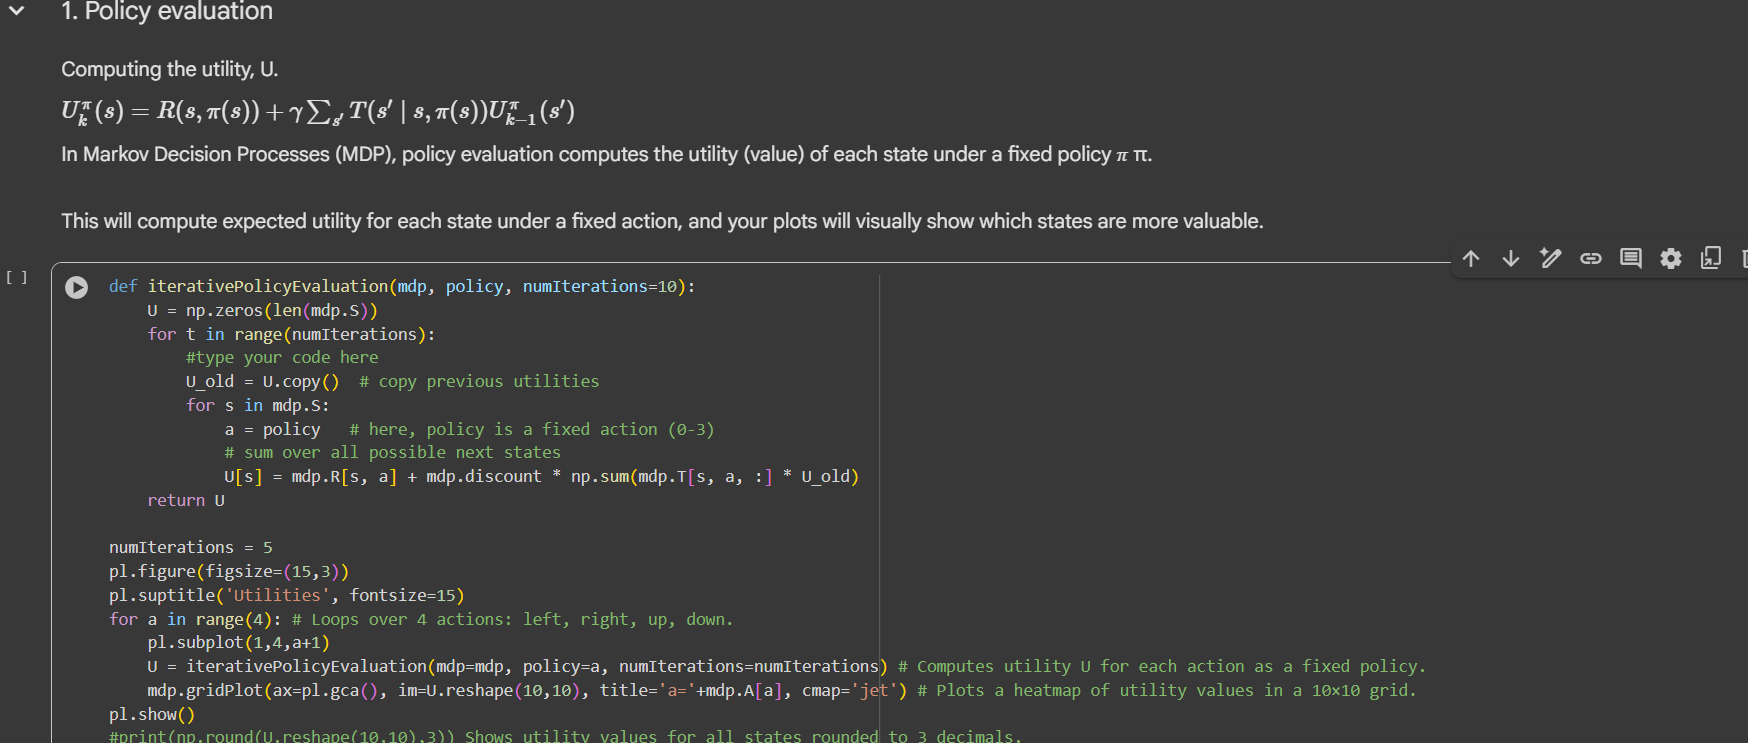

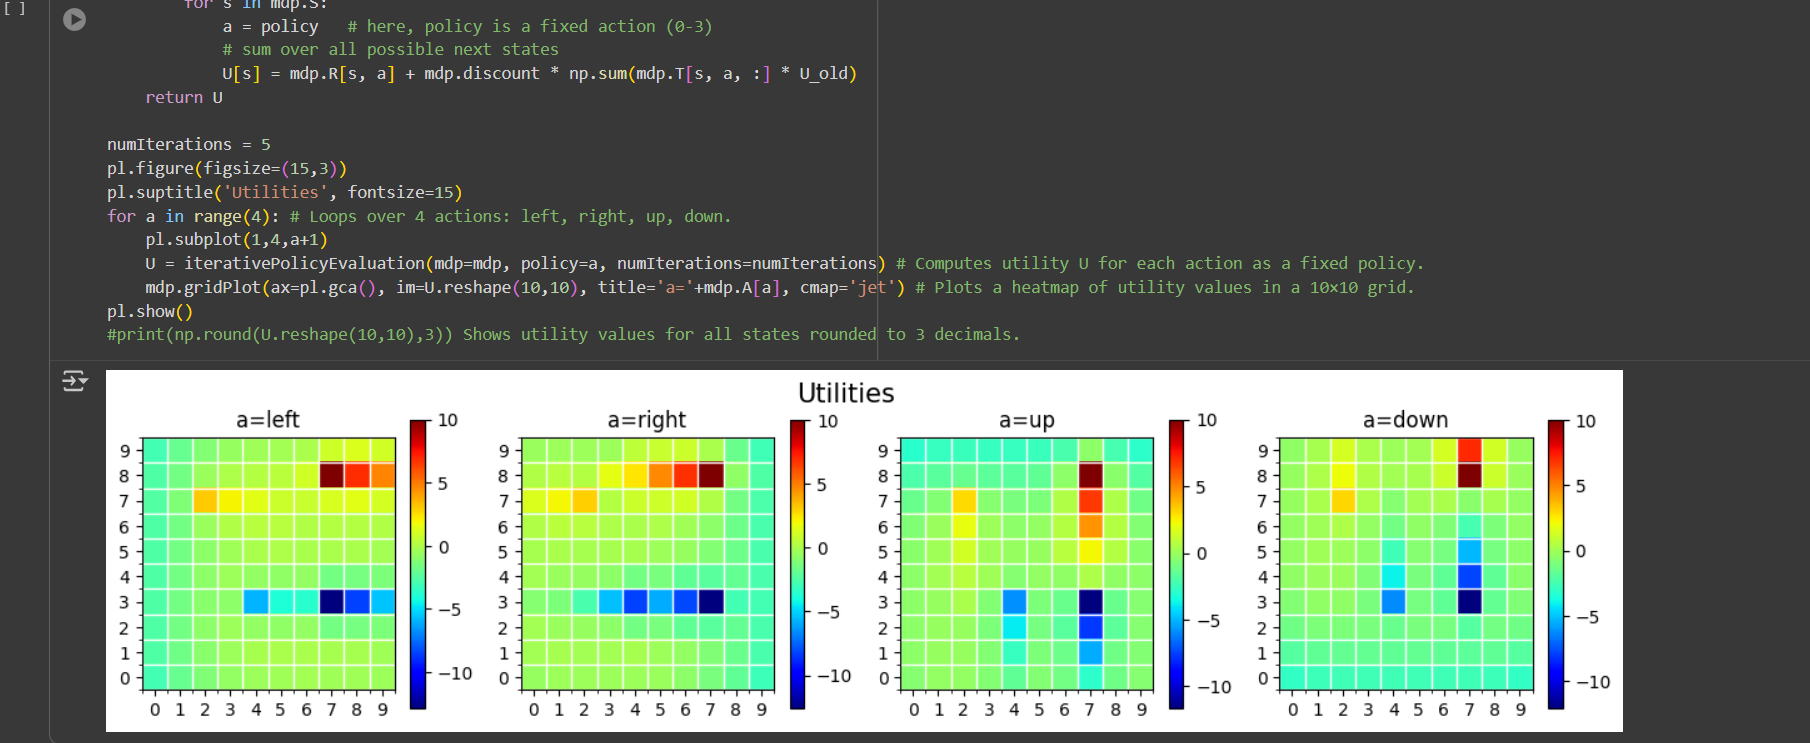

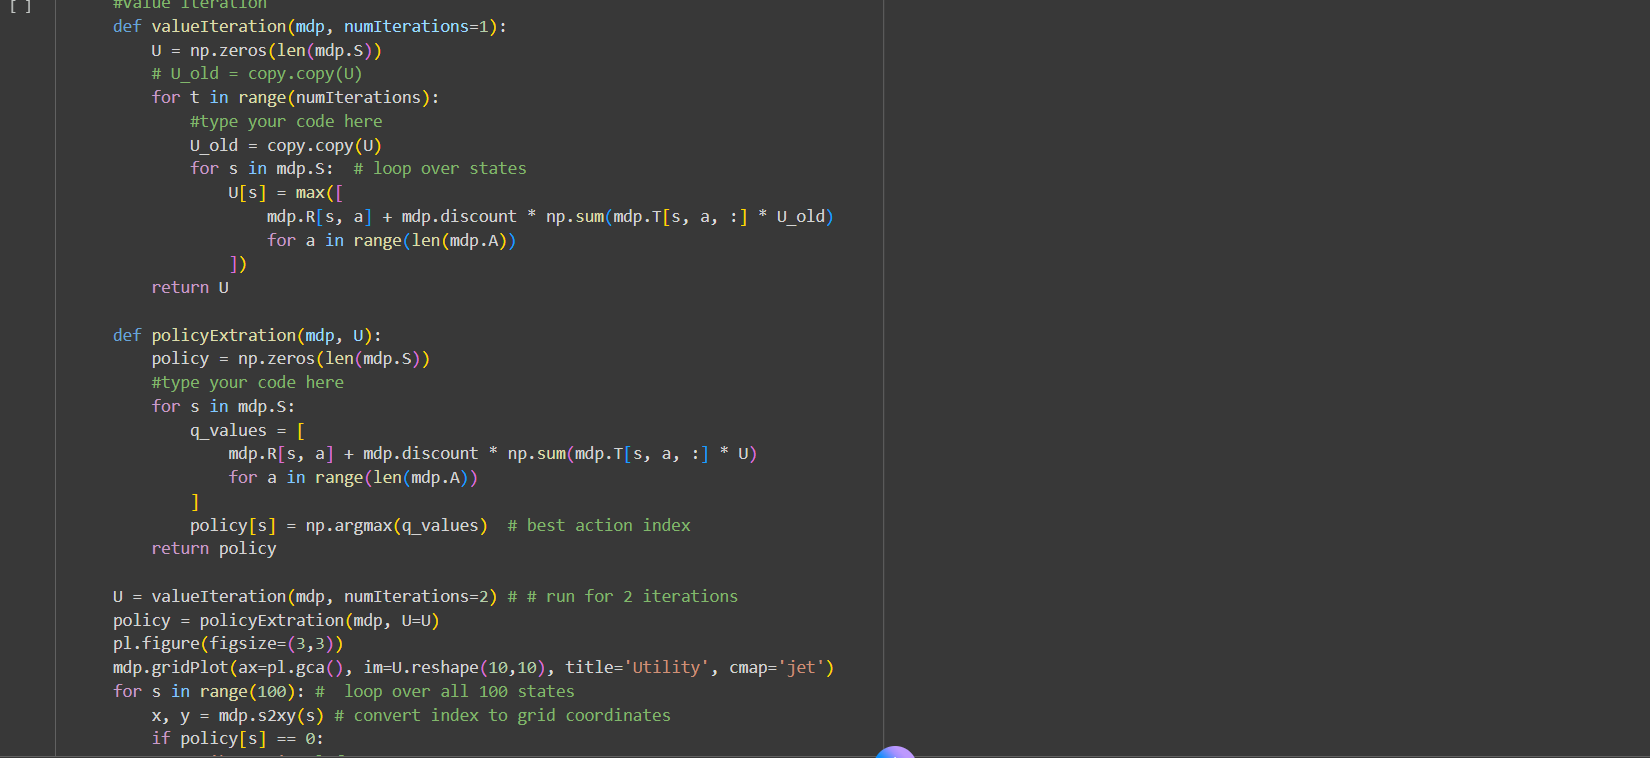

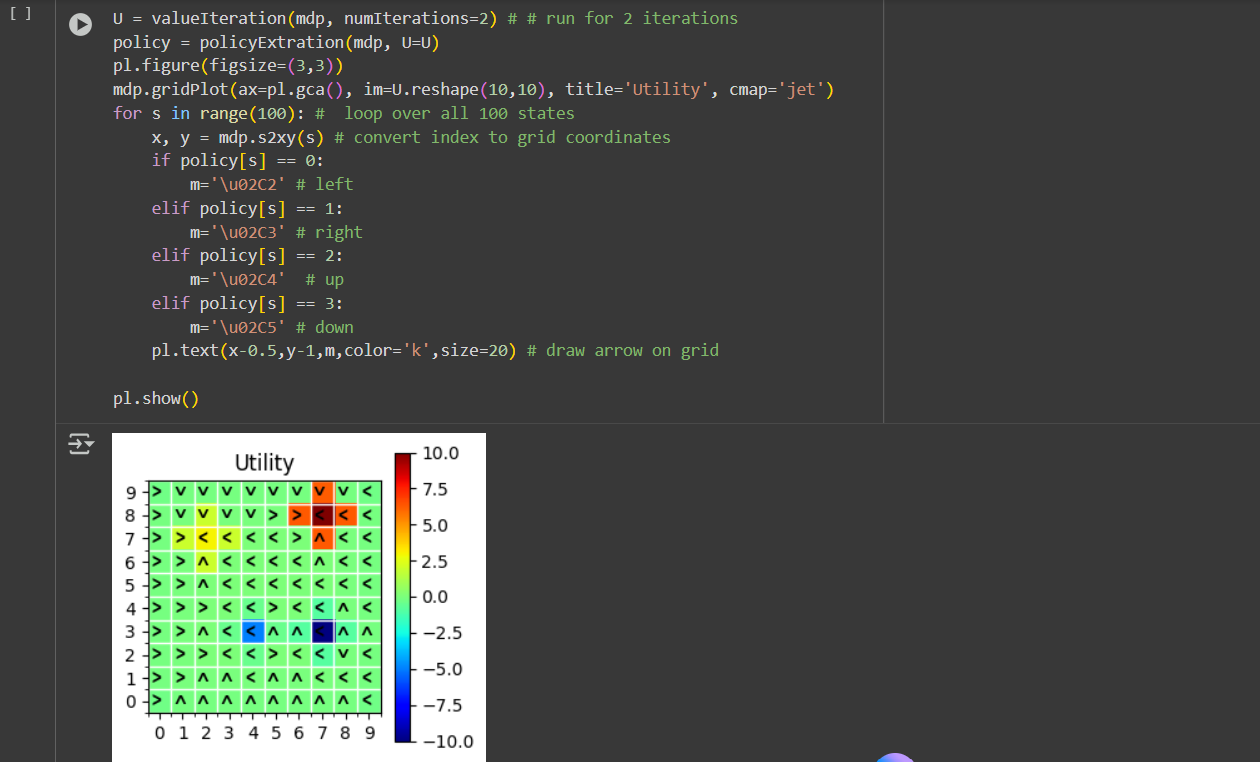

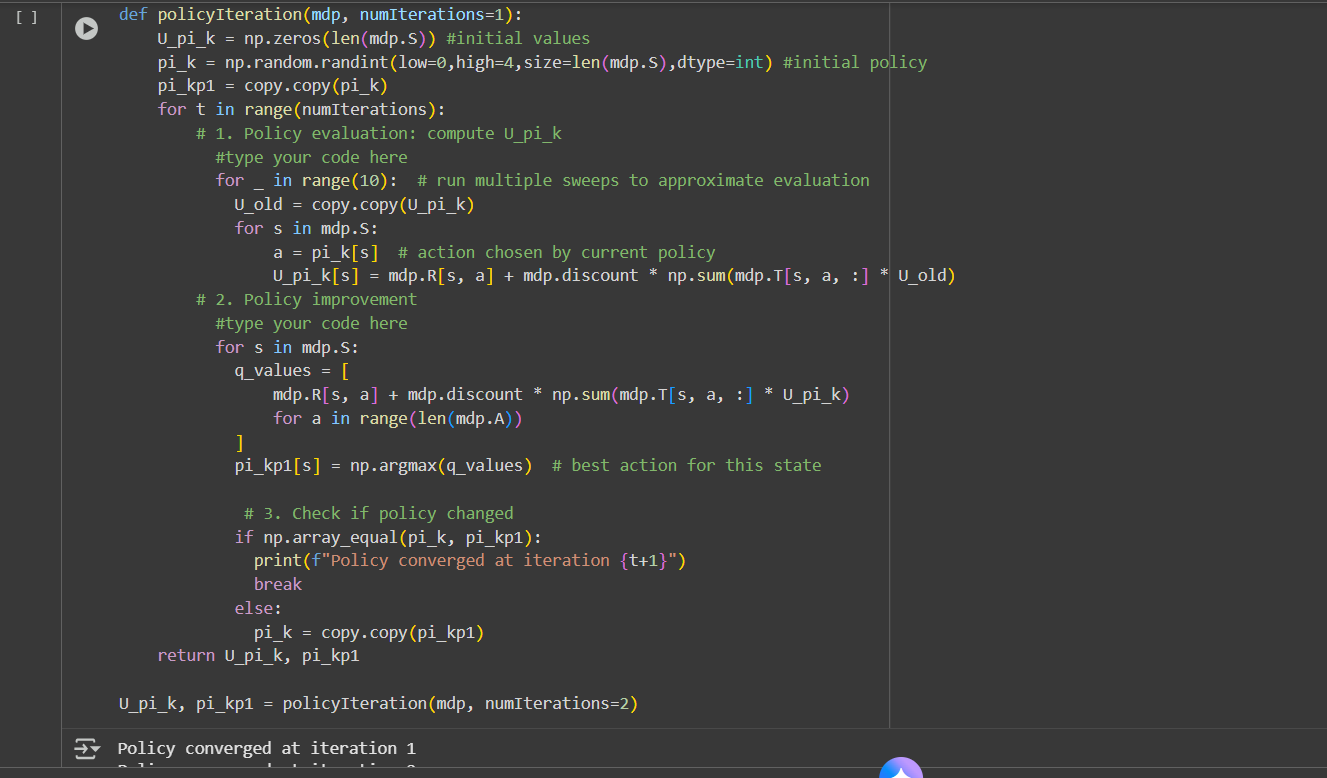

**Task 02**

Model Based

*   Model-Based RL requires transition probabilities and rewards.
*   planining ahead using the model
*   faster convergence if model is accurate
*   Works well when model is known

Model Free
*   No knowledge needed, learns from experience
*   Trial and error interaction
*   slower, needs more samples
*   works even when model is unknown
learns Q value directly from interactions.

